In [1]:
#Importing the library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
import seaborn as sns # Ensure seaborn
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Loading the file 
df = pd.read_csv("gold_sa_historical_data_2020_onwards.csv")
print("File Loaded complete")

File Loaded complete


In [3]:
# --- STEP 1: GUARANTEE DATA INTEGRITY (The Final Fix) ---
# Ensure the date column is clean, set as the index, and the price_series is a clean copy.
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date']).dt.normalize()
    df = df.set_index('date').sort_index(ascending=True)
elif not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.to_datetime(df.index).tz_localize(None)

In [4]:
df.head()

,price_24k_usd
date,
2020-01-01 00:00:00+00:00,9.767883
2020-01-02 00:00:00+00:00,9.830062
2020-01-03 00:00:00+00:00,9.969354
2020-01-04 00:00:00+00:00,9.975177
2020-01-05 00:00:00+00:00,10.092365


In [5]:
#Accurate Price Conversion Factor Calculation
PRECISE_FACTOR = 140.13 / 27.2563596441
print(f"PRECISE_FACTOR = {PRECISE_FACTOR}, final price per gram")

#Vectorized Calculation
df["price_24k_usd_per_gram"] = df["price_24k_usd"] * PRECISE_FACTOR

#Now We Change the currency from USD to Saudi Riyal (SAR)
df["price_24k_sar_per_gram"] = df["price_24k_usd_per_gram"] * 3.75
df


PRECISE_FACTOR = 5.1411854638604675, final price per gram


,price_24k_usd,price_24k_usd_per_gram,price_24k_sar_per_gram
date,,,
2020-01-01 00:00:00+00:00,9.767883,50.218499,188.319371
2020-01-02 00:00:00+00:00,9.830062,50.538170,189.518136
2020-01-03 00:00:00+00:00,9.969354,51.254297,192.203615
2020-01-04 00:00:00+00:00,9.975177,51.284234,192.315879
2020-01-05 00:00:00+00:00,10.092365,51.886721,194.575205
...,...,...,...
2025-10-16 00:00:00+00:00,27.067643,139.159772,521.849146
2025-10-17 00:00:00+00:00,28.074091,144.334106,541.252898
2025-10-18 00:00:00+00:00,27.342950,140.575179,527.156920


In [6]:
# 3. Drop unused columns to keep the DataFrame clean
df = df.drop(columns=['price_24k_usd', 'price_24k_usd_per_gram'])

In [7]:
price_series = df['price_24k_sar_per_gram'].copy()
print(f"Final data end date for model fit: {price_series.index.max().date()}")

Final data end date for model fit: 2025-10-20


In [8]:
price_series

date
2020-01-01 00:00:00+00:00    188.319371
2020-01-02 00:00:00+00:00    189.518136
2020-01-03 00:00:00+00:00    192.203615
2020-01-04 00:00:00+00:00    192.315879
2020-01-05 00:00:00+00:00    194.575205
                                ...    
2025-10-16 00:00:00+00:00    521.849146
2025-10-17 00:00:00+00:00    541.252898
2025-10-18 00:00:00+00:00    527.156920
2025-10-19 00:00:00+00:00    527.104022
2025-10-20 00:00:00+00:00    525.487500
Name: price_24k_sar_per_gram, Length: 2113, dtype: float64

In [9]:
# --- STEP 2: FIT THE FINAL ARIMA MODEL ---
print("\nFitting FINAL ARIMA(0, 1, 0) model on the full price_series...")
model = ARIMA(price_series, order=(0, 1, 0))
model_fit_eval = model.fit() 
last_train_date = model_fit_eval.data.row_labels[-1] 
print(f"Model successfully fitted. Forecast will start after: {last_train_date.date()}")


Fitting FINAL ARIMA(0, 1, 0) model on the full price_series...
Model successfully fitted. Forecast will start after: 2025-10-20


In [10]:
# Calculate Log Returns (The series to be modeled)
log_returns = np.log(price_series).diff().dropna() * 100

In [11]:
# Seeing the hybrid approach
print("\n--- Fitting ARIMA(0, 1, 0) - GARCH(1, 1) model on Full Data ---")
# mean='Constant' models log_returns = mu + epsilon_t (equivalent to ARIMA(0,1,0) on price)
# dist='t' uses the Student's t distribution, which is often better for financial data
am = arch_model(
    log_returns, 
    mean='Constant', 
    vol='Garch', 
    p=1, q=1,
    dist='t' 
)

res = am.fit(disp='off')

# --- 3. Print the Summary ---
print("\n--- FINAL MODEL SUMMARY ---")
print(res.summary())


--- Fitting ARIMA(0, 1, 0) - GARCH(1, 1) model on Full Data ---

--- FINAL MODEL SUMMARY ---
                        Constant Mean - GARCH Model Results                         
Dep. Variable:       price_24k_sar_per_gram   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -2313.56
Distribution:      Standardized Student's t   AIC:                           4637.12
Method:                  Maximum Likelihood   BIC:                           4665.40
                                              No. Observations:                 2112
Date:                      Thu, Jan 01 2026   Df Residuals:                     2111
Time:                              16:35:23   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0

In [12]:
# --- Part 1: Define Parameters ---
forecast_steps = 365
VOLATILITY_FACTOR = 1.0

# --- Part 2 & 3: Generate Forecast and Correct DatetimeIndex ---
print(f"Generating a {forecast_steps}-day forecast...")
raw_forecast_results = model_fit_eval.get_forecast(steps=forecast_steps)
forecast_mean = raw_forecast_results.predicted_mean.copy()

data_freq = pd.infer_freq(model_fit_eval.data.row_labels) or "D"
# Index starts the day AFTER the last training date
forecast_index = pd.date_range(start=last_train_date, periods=forecast_steps + 1, freq=data_freq)[1:]
forecast_mean.index = forecast_index


Generating a 365-day forecast...


In [13]:
# --- Part 4: Calculate the Final Scaled Confidence Interval ---
forecast_ci_standard = raw_forecast_results.conf_int(alpha=0.05)
forecast_ci_standard.columns = ["lower", "upper"]
forecast_ci_standard.index = forecast_index
mid_point = forecast_mean
standard_margin_of_error = (forecast_ci_standard['upper'] - forecast_ci_standard['lower']) / 2
scaled_margin_of_error = standard_margin_of_error * VOLATILITY_FACTOR
forecast_ci_scaled = pd.DataFrame({
    "lower": mid_point - scaled_margin_of_error,
    "upper": mid_point + scaled_margin_of_error
})


In [14]:
print(f"Average Predicted Price: {mid_point.iloc[-1]}")
print(f"Lower Bound (95% Scaled CI): {forecast_ci_scaled["lower"].iloc[-1]}")
print(f"Upper Bound (95% Scaled CI): {forecast_ci_scaled["upper"].iloc[-1]}")

Average Predicted Price: 525.4875
Lower Bound (95% Scaled CI): 438.0117551945955
Upper Bound (95% Scaled CI): 612.9632448054044


In [15]:
# --- Part 5: Create CONNECTED Data for a Seamless Plot ---
last_hist_date = model_fit_eval.data.row_labels[-1]
last_hist_value = price_series.loc[last_hist_date]

start_point_mean = pd.Series({last_hist_date: last_hist_value})
start_point_ci = pd.DataFrame({"lower": [last_hist_value], "upper": [last_hist_value]}, index=[last_hist_date])

forecast_mean_connected = pd.concat([start_point_mean, forecast_mean])
forecast_ci_connected = pd.concat([start_point_ci, forecast_ci_scaled])

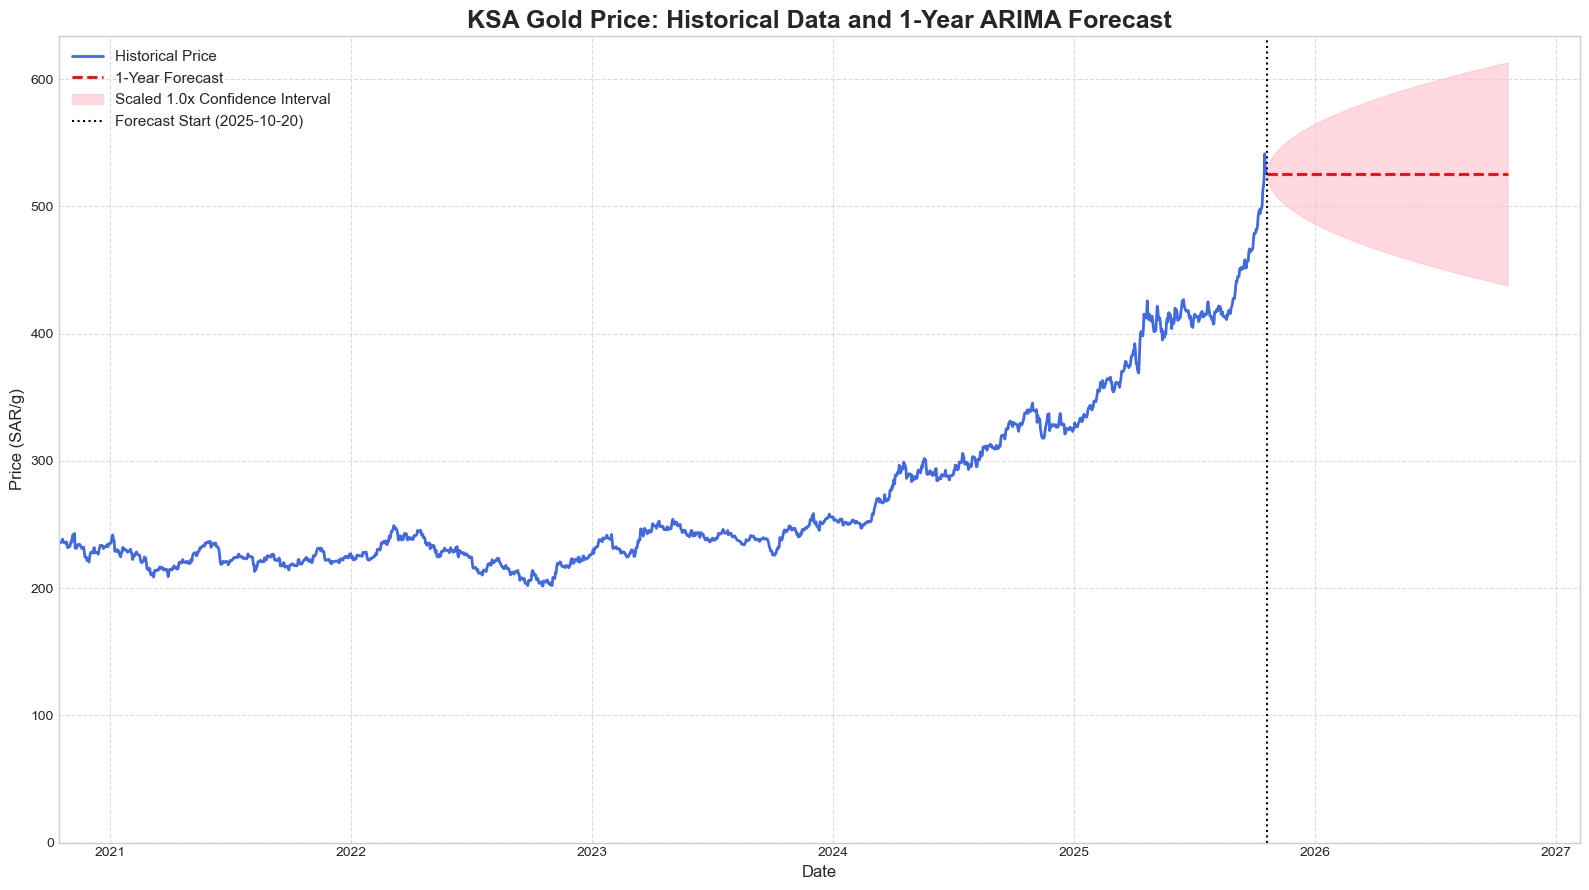


Confidence Interval was scaled by a factor of 1.0 to reflect real-world volatility.


In [16]:
# --- 6. Plot the Final Results ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(16, 9))

recent_historical_data = price_series.tail(1825) 
plt.plot(recent_historical_data.index, recent_historical_data, label='Historical Price', color='royalblue', linewidth=2)

plt.plot(forecast_mean_connected.index, forecast_mean_connected, label='1-Year Forecast', color='red', linestyle='--', linewidth=2)

plt.fill_between(
    forecast_ci_connected.index,
    forecast_ci_connected["lower"],
    forecast_ci_connected["upper"],
    color='pink', alpha=0.6, label=f'Scaled {VOLATILITY_FACTOR}x Confidence Interval'
)

plt.title('KSA Gold Price: Historical Data and 1-Year ARIMA Forecast', fontsize=18, fontweight='bold')
plt.ylabel('Price (SAR/g)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.axvline(last_hist_date, color='black', linestyle=':', linewidth=1.5, label=f'Forecast Start ({last_hist_date.date()})')
plt.xlim(left=recent_historical_data.index.min())
plt.ylim(bottom=0)
plt.legend(loc='upper left', fontsize=11)
plt.tight_layout()
plt.show()

print(f"\nConfidence Interval was scaled by a factor of {VOLATILITY_FACTOR} to reflect real-world volatility.")

Fitting ARIMA(0, 0, 0) model...
                               SARIMAX Results                                
Dep. Variable:            Log Returns   No. Observations:                 2112
Model:                          ARIMA   Log Likelihood               -2614.517
Date:                Thu, 01 Jan 2026   AIC                           5233.034
Time:                        16:35:23   BIC                           5244.345
Sample:                             0   HQIC                          5237.176
                               - 2112                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0486      0.018      2.659      0.008       0.013       0.084
sigma2         0.6963      0.011     61.147      0.000       0.674       0.719
Ljung-Box (L1) (Q): 

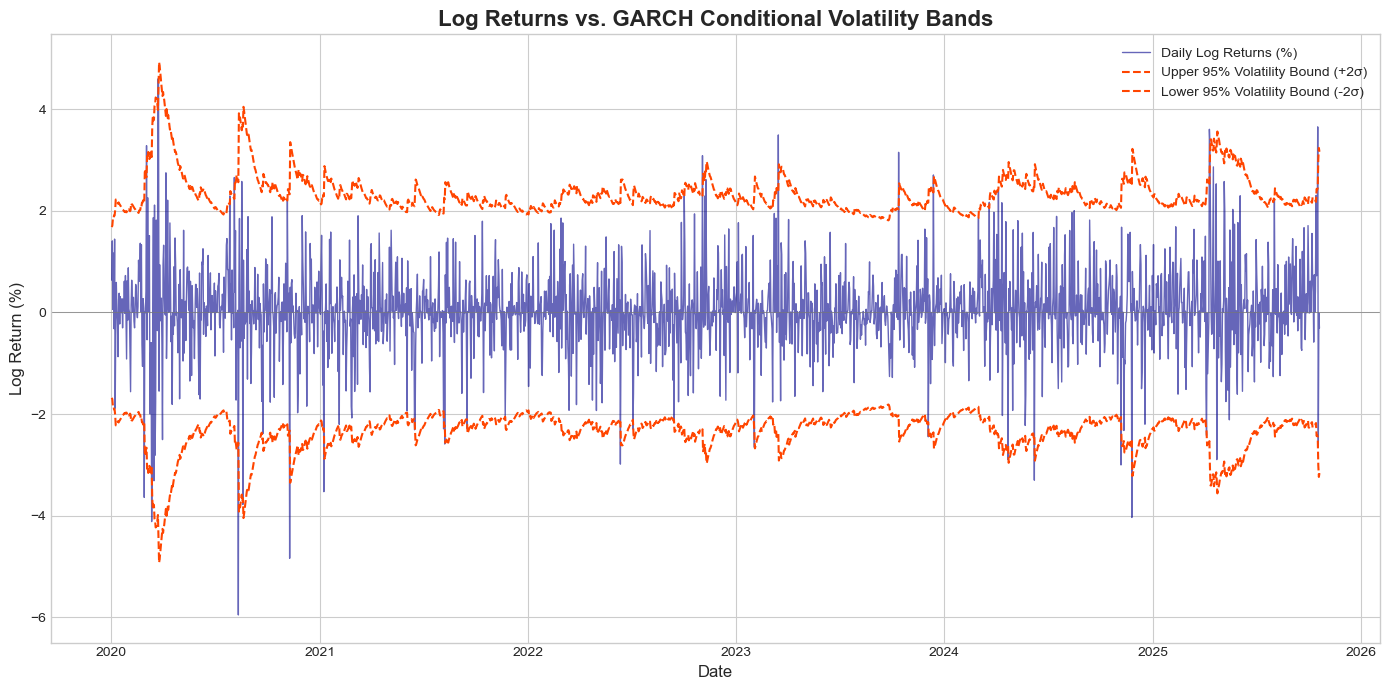

In [17]:
def plot_arima_garch_comparison(series = price_series, arima_order=(0, 0, 0), garch_order=(1, 1), dist='t'):
    """
    Fits an ARIMA+GARCH model to a time series and plots the returns against
    the conditional volatility estimated by the GARCH model.

    Args:
        series (pd.Series): The input time series (e.g., asset prices).
        arima_order (tuple): The (p, d, q) order for the ARIMA model.
        garch_order (tuple): The (p, q) order for the GARCH model.
        dist (str): The distribution for the GARCH model ('Normal' or 't').
    """
    # --- 1. Data Preparation: Calculate Log Returns ---
    log_returns = np.log(series / series.shift(1)).dropna() * 100
    log_returns.name = 'Log Returns'

    # --- 2. Fit ARIMA Model to the Returns ---
    # (0,0,0) is used to model the mean only, as linear terms were non-significant.
    print(f"Fitting ARIMA{arima_order} model...")
    arima_model = ARIMA(log_returns, order=arima_order).fit()
    print(arima_model.summary())
    
    arima_residuals = arima_model.resid

    # --- 3. Fit GARCH Model to ARIMA Residuals ---
    # Using 't' distribution to account for financial data's "fat tails" (high kurtosis).
    print(f"\nFitting GARCH{garch_order} model on ARIMA residuals with {dist.upper()} distribution...")
    garch_model = arch_model(
        arima_residuals,
        vol='Garch',
        p=garch_order[0],
        q=garch_order[1],
        dist=dist
    ).fit(disp='off')
    print(garch_model.summary())

    conditional_volatility = garch_model.conditional_volatility

    # --- 4. Create the Comparison Plot (Your Combined Idea!) ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(14, 7))

    # Plot 1: Log Returns
    ax.plot(
        log_returns,
        label='Daily Log Returns (%)',
        color='darkblue',
        alpha=0.6,
        linewidth=1.0
    )
    
    # Plot 2 & 3: Conditional Volatility Bounds (±2*sigma = 95% Risk Band)
    ax.plot(
        conditional_volatility * 2,
        label='Upper 95% Volatility Bound (+2σ)',
        color='orangered',
        linestyle='--',
        linewidth=1.5
    )
    ax.plot(
        -conditional_volatility * 2,
        label='Lower 95% Volatility Bound (-2σ)',
        color='orangered',
        linestyle='--',
        linewidth=1.5
    )

    # Final Touches
    ax.axhline(0, color='grey', linestyle='-', linewidth=0.5) 
    ax.set_title('Log Returns vs. GARCH Conditional Volatility Bands', fontsize=16, fontweight='bold')
    ax.set_ylabel('Log Return (%)', fontsize=12)
    ax.set_xlabel('Date', fontsize=12)
    ax.legend(loc='upper right', fontsize=10)
    plt.tight_layout()
    plt.savefig('garch_volatility_bands_plot.png')
    plt.show()


# ====================================================================
# --- 5. Application on Real KSA Gold Price Data ---
# 
# IMPORTANT: You must ensure 'price_series' is correctly defined 
# and contains your KSA Gold Price data before running this line!
#
# Using the recommended (0,0,0) ARIMA and Student's t distribution:
plot_arima_garch_comparison(
    series=price_series, 
    arima_order=(0, 0, 0),
    garch_order=(1, 1),
    dist='t'
)

The entire problem revolved around memory and data integrity in the Jupyter environment, not an error in the core math or logic.



### **Initial State: Misalignment of Variables**

#### What happend?
- The forecast started five years in the past (around 2020). 
#### Why it happend?
- The plotting code was using an old variable, like train_data_eval, that was truncated during an earlier train/test split.
#### The Fix:
- We replaced the old, truncated variable with the correct, dynamic model reference: last_train_date = model_fit_eval.data.row_labels[-1]. This forced the plot to use the last date the model saw, which led to the next, more subtle error.

### **Model Memory Contamination (The Core Problem)**

#### What happend?
- The forecast shifted forward but still had a gap, starting on 2025-07-23 instead of 2025-10-21.
#### Why it happend?
- This was the most persistent error. The ARIMA model's memory (model_fit_eval) was "contaminated." It was initialized and fitted once on an old, truncated version of your data that physically ended on 2025-07-22.
#### The Problem:
- Even when you provided the full, correct data (price_series) to the model later, the model object had its internal index structure permanently locked to the shorter 2025-07-22 date.

### **The Final Obstacle: The Memory Reset**

#### What happend?
- All attempts to fix the date failed, even when running the correct model.fit() code.
#### Why it happend?
- The underlying data variable (price_series) in the notebook's memory was physically truncated. A preceding, forgotten line of code had likely overwritten the full dataset (df) with the shorter version, and no amount of fixing or re-running could restore it without a full kernel restart.
#### The Solution:
- decision to copy the final, correct code into a new notebook was the ultimate solution. A new notebook guarantees a fresh memory state, forcing the system to: 1) Load the full data correctly, and 2) Fit the model onto the correct, clean data for the first time.